# CELLEX

In [1]:
import pandas as pd
import cellex
import h5py
import pyreadr
import scanpy as sc
from pathlib import Path
from functools import reduce

In [2]:
DATA_DIR = "/home/eerdem/notebooks/CELLECT-Analyser/data/CELLEX"

In [3]:
%%time
metadata_file = f"{DATA_DIR}/df_cell.RDS"
result = pyreadr.read_r(metadata_file) 
metadata = result[None] 
metadata = metadata[metadata['Organ']=='Cerebrum'].reset_index(drop=True)
dropped_metadata = metadata[metadata['Organ_cell_lineage'].notna()]
cell_types = dropped_metadata['Organ_cell_lineage'].unique()
display(cell_types)

array(['Cerebrum-Excitatory neurons', 'Cerebrum-Inhibitory neurons',
       'Cerebrum-Astrocytes', 'Cerebrum-SKOR2_NPSR1 positive cells',
       'Cerebrum-Oligodendrocytes', 'Cerebrum-Microglia',
       'Cerebrum-Vascular endothelial cells',
       'Cerebrum-Limbic system neurons', 'Cerebrum-Megakaryocytes'],
      dtype=object)

CPU times: user 36.9 s, sys: 2.22 s, total: 39.1 s
Wall time: 39.1 s


In [4]:
dropped_metadata.groupby('Organ_cell_lineage').size()

Organ_cell_lineage
Cerebrum-Astrocytes                      49115
Cerebrum-Excitatory neurons            1258818
Cerebrum-Inhibitory neurons             350759
Cerebrum-Limbic system neurons           45989
Cerebrum-Megakaryocytes                     36
Cerebrum-Microglia                        4459
Cerebrum-Oligodendrocytes                17644
Cerebrum-SKOR2_NPSR1 positive cells      15005
Cerebrum-Vascular endothelial cells       9421
dtype: int64

In [5]:
genename_file = f"{DATA_DIR}/df_gene.RDS"
genenames_df = pyreadr.read_r(genename_file) 
genenames_df = genenames_df[None] 
genenames = genenames_df['gene_id'].str.split('.').str[0]

In [6]:
genenames

0        ENSG00000223972
1        ENSG00000227232
2        ENSG00000243485
3        ENSG00000237613
4        ENSG00000268020
              ...       
63556    ENSG00000240779
63557    ENSG00000244656
63558    ENSG00000263760
63559    ENSG00000222670
63560    ENSG00000251180
Name: gene_id, Length: 63561, dtype: object

## Sampling the data
The dataset was sampled multiple times since the descartes data is too large to completely analyse in one go.
Since there are few Megakaryocytes we takes these all the time during sampling:

We sample them in python and save the positions in a text file.

In [ ]:
min_count = dropped_metadata.groupby('Organ_cell_lineage').size().min()
for i in range(0,10):
    sampled_pos = []
    sampled_pos = (dropped_metadata.sample(9*2000).index + 1).to_list() # +1 for R counting
    megakar_pos = (dropped_metadata[
        (dropped_metadata['Organ_cell_lineage']=='Cerebrum-Megakaryocytes')
    ].index +1).to_list() # get the megakar positions
    all_sampled_pos = list(set(sampled_pos + megakar_pos))
    outfile = f'{DATA_DIR}/positions{i}.txt'
    with open(outfile,'w') as file:
        for line in all_sampled_pos:
            file.write(f'{line}\n')

In R we load the data and sample them with the positions.txt files and save to h5 format.

In [ ]:
!Rscript Descartes_Human_Cerebrum.R

In [7]:
h5file = f'{DATA_DIR}/Cerebrum_gene_count.h5'
with h5py.File(h5file, 'r') as f:
    samples = list(f.keys())
    print(f.keys())

<KeysViewHDF5 ['sample0', 'sample1', 'sample2', 'sample3', 'sample4', 'sample5', 'sample6', 'sample7', 'sample8', 'sample9']>


In [8]:
SAMPLE = 9 # the sampled data was saved in a .h5 file where the keys were named sample0, sample1, etc.

In [9]:
%%time
with h5py.File(h5file, 'r') as f:
    grpname = f.require_group(f'/sample{SAMPLE}')
    print(grpname.keys())
    colnames = list(f[f'/sample{SAMPLE}/colnames'])
colnames = [name.decode() for name in colnames]
sampledh5_df = sc.read_hdf(h5file, key=f'sample{SAMPLE}/data').to_df().T
sampledh5_df.index = genenames
sampledh5_df.columns = colnames

<KeysViewHDF5 ['colnames', 'data']>
CPU times: user 23 s, sys: 6.26 s, total: 29.3 s
Wall time: 29.3 s


In [10]:
sampledh5_df

,exp5-human-158well.CGGTTCCATTCGAGGAGTA,exp5-human-117well.GCGGTATATGATACGGAAC,exp2-human-426_.TACTTGCGTCGAGCTGCCA,exp5-human-158well.CAAGCAACTAGCGTCAATG,exp2-human-300_.TCTATCCAATATTGCGCTGA,exp5-human-117well.ACAGGTATTTGGCTCTCTAT,exp5-human-709well.ACGAGGTTTTTGCGAGGCA,exp3-human-238well.GGTACCATTAATTATCAGC,exp5-human-709well.CTGATAGGTTGATAGAACG,exp2-human-70_.TGCCTTGGTGGTATGCTTG,...,exp5-human-235well.TCTACTTACTGCCGGTCGAG,exp5-human-709well.AATACCGAATAGCCGGTACC,exp1-human-470.ACATTCGTATGGATCTGCAG,exp3-human-24well.AACTTGGATTCCAACTAACC,exp5-human-817well.GGAGGTTCTGTATAATACG,exp3-human-238well.ATATCTGGATGACTAGTCTA,exp3-human-469well.ATTGAGGAATTTATAAGAAC,exp5-human-860well.ATAAGCGAATTCTGATACCA,exp5-human-305well.TGACGAGGTCGCCGCCTCC,exp3-human-469well.CGGTAAGGTCATTATTACC
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000223972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000227232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000243485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000237613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000268020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000240779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000244656,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000263760,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
sampled_metadata = pd.merge(sampledh5_df.columns.to_frame().reset_index()[['index']],
                           dropped_metadata[['sample','Organ_cell_lineage']],
                           left_on='index', right_on='sample')
sampled_metadata['Organ_cell_lineage'].value_counts()

Cerebrum-Excitatory neurons            12890
Cerebrum-Inhibitory neurons             3597
Cerebrum-Astrocytes                      511
Cerebrum-Limbic system neurons           488
Cerebrum-Oligodendrocytes                180
Cerebrum-SKOR2_NPSR1 positive cells      164
Cerebrum-Vascular endothelial cells      112
Cerebrum-Microglia                        58
Cerebrum-Megakaryocytes                   36
Name: Organ_cell_lineage, dtype: int64

In [12]:
sampled_metadata = sampled_metadata[['sample','Organ_cell_lineage']]
data = sampledh5_df.loc[:,sampledh5_df.columns.isin(sampled_metadata['sample'])]
sampled_metadata.set_index('sample', inplace=True)

In [13]:
display(data, sampled_metadata)

,exp5-human-158well.CGGTTCCATTCGAGGAGTA,exp5-human-117well.GCGGTATATGATACGGAAC,exp2-human-426_.TACTTGCGTCGAGCTGCCA,exp5-human-158well.CAAGCAACTAGCGTCAATG,exp2-human-300_.TCTATCCAATATTGCGCTGA,exp5-human-117well.ACAGGTATTTGGCTCTCTAT,exp5-human-709well.ACGAGGTTTTTGCGAGGCA,exp3-human-238well.GGTACCATTAATTATCAGC,exp5-human-709well.CTGATAGGTTGATAGAACG,exp2-human-70_.TGCCTTGGTGGTATGCTTG,...,exp5-human-235well.TCTACTTACTGCCGGTCGAG,exp5-human-709well.AATACCGAATAGCCGGTACC,exp1-human-470.ACATTCGTATGGATCTGCAG,exp3-human-24well.AACTTGGATTCCAACTAACC,exp5-human-817well.GGAGGTTCTGTATAATACG,exp3-human-238well.ATATCTGGATGACTAGTCTA,exp3-human-469well.ATTGAGGAATTTATAAGAAC,exp5-human-860well.ATAAGCGAATTCTGATACCA,exp5-human-305well.TGACGAGGTCGCCGCCTCC,exp3-human-469well.CGGTAAGGTCATTATTACC
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000223972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000227232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000243485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000237613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000268020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000240779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000244656,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000263760,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,Organ_cell_lineage
sample,
exp5-human-158well.CGGTTCCATTCGAGGAGTA,Cerebrum-Inhibitory neurons
exp5-human-117well.GCGGTATATGATACGGAAC,Cerebrum-Oligodendrocytes
exp2-human-426_.TACTTGCGTCGAGCTGCCA,Cerebrum-Excitatory neurons
exp5-human-158well.CAAGCAACTAGCGTCAATG,Cerebrum-Excitatory neurons
exp2-human-300_.TCTATCCAATATTGCGCTGA,Cerebrum-Inhibitory neurons
...,...
exp3-human-238well.ATATCTGGATGACTAGTCTA,Cerebrum-Excitatory neurons
exp3-human-469well.ATTGAGGAATTTATAAGAAC,Cerebrum-Excitatory neurons
exp5-human-860well.ATAAGCGAATTCTGATACCA,Cerebrum-Inhibitory neurons


In [14]:
%%time
eso = cellex.ESObject(data=data,
                      annotation=sampled_metadata,
                      verbose=True)

Preprocessing - checking input ... input parsed in 0 min 0 sec
Preprocessing - running remove_non_expressed ... excluded 29751 / 63561 genes in 0 min 26 sec
Preprocessing - normalizing data ... data normalized in 0 min 15 sec
Preprocessing - running ANOVA ... excluded 25018 / 33810 genes in 0 min 12 sec
CPU times: user 31.8 s, sys: 42.2 s, total: 1min 13s
Wall time: 1min 2s


In [15]:
%%time
eso.compute(verbose=True)

Computing DET ... 
    esw ...
    empirical p-values ...
    esw_s ...
    finished in 0 min 1 sec
Computing EP ...
    esw ...
    empirical p-values ...
    esw_s ...
    finished in 0 min 0 sec
Computing GES ...
    esw ...
    empirical p-values ...
    esw_s ...
    finished in 0 min 6 sec
Computing NSI ...
    esw ...
    empirical p-values ...
    esw_s ...
    finished in 0 min 0 sec
Computing ESmu ...
    finished in 0 min 0 sec
Computing ESsd ...
    finished in 0 min 0 sec
Computed ['det.esw', 'det.esw_null', 'det.pvals', 'det.esw_s', 'ep.esw', 'ep.esw_null', 'ep.pvals', 'ep.esw_s', 'ges.esw', 'ges.esw_null', 'ges.pvals', 'ges.esw_s', 'nsi.esw', 'nsi.esw_null', 'nsi.pvals', 'nsi.esw_s', 'esmu', 'essd'].
CPU times: user 4.78 s, sys: 4.36 s, total: 9.14 s
Wall time: 8.03 s


In [16]:
eso.results['esmu']

,Cerebrum-Astrocytes,Cerebrum-Excitatory neurons,Cerebrum-Inhibitory neurons,Cerebrum-Limbic system neurons,Cerebrum-Megakaryocytes,Cerebrum-Microglia,Cerebrum-Oligodendrocytes,Cerebrum-SKOR2_NPSR1 positive cells,Cerebrum-Vascular endothelial cells
gene,,,,,,,,,
ENSG00000237683,0.000000,0.044753,0.000000,0.000000,0.000000,0.630457,0.000000,0.000000,0.000000
ENSG00000237094,0.000000,0.000000,0.000000,0.146028,0.736140,0.000000,0.000000,0.000000,0.000000
ENSG00000248527,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.483063
ENSG00000228794,0.000000,0.000000,0.000000,0.303600,0.000000,0.027454,0.000000,0.000000,0.058517
ENSG00000188290,0.000000,0.000000,0.000000,0.010453,0.000000,0.000000,0.000000,0.000000,0.415372
...,...,...,...,...,...,...,...,...,...
ENSG00000215781,0.019499,0.000000,0.000000,0.025776,0.000000,0.000000,0.129703,0.000000,0.000000
ENSG00000215608,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.678933
ENSG00000220023,0.000000,0.000000,0.047638,0.283302,0.000000,0.000000,0.000000,0.012155,0.000000


In [17]:
out = f'{DATA_DIR}/Descartes_Human_Cerebrum_sample{SAMPLE}.esmu.csv'
eso.results["esmu"].to_csv(out)

## Combining the sampled esmu files

In [18]:
directory = DATA_DIR
df_list = []
for path in Path(directory).glob('*[0-9].esmu.csv'):
    n = path.stem[-6]
    df = pd.read_csv(path)
    df.set_index('gene', inplace=True)
    df = df.melt(ignore_index=False)
    df.rename(columns={'variable':'cell-type','value':f'ES{n}'}, inplace=True)
    df_list.append(df)
df_list = [df.reset_index() for df in df_list]   

In [19]:
df_merged = reduce(lambda left,right: pd.merge(left, right, on=['gene','cell-type']), df_list)
df_merged

,gene,cell-type,ES5,ES2,ES4,ES3,ES0,ES8,ES7,ES1,ES6,ES9
0,ENSG00000237094,Cerebrum-Astrocytes,0.000000,0.000000,0.000000,0.000000,0.000000,0.112194,0.000000,0.000000,0.000000,0.00000
1,ENSG00000188290,Cerebrum-Astrocytes,0.153941,0.186675,0.289749,0.000000,0.231735,0.035098,0.183348,0.190532,0.267989,0.00000
2,ENSG00000179403,Cerebrum-Astrocytes,0.000000,0.000000,0.000000,0.182790,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
3,ENSG00000078369,Cerebrum-Astrocytes,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
4,ENSG00000142609,Cerebrum-Astrocytes,0.426254,0.373870,0.155302,0.305815,0.437674,0.529371,0.249535,0.412439,0.206070,0.71783
...,...,...,...,...,...,...,...,...,...,...,...,...
46651,ENSG00000241859,Cerebrum-Vascular endothelial cells,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
46652,ENSG00000165246,Cerebrum-Vascular endothelial cells,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
46653,ENSG00000176728,Cerebrum-Vascular endothelial cells,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
46654,ENSG00000229236,Cerebrum-Vascular endothelial cells,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


In [20]:
df = df_merged.set_index(['gene','cell-type']).mean(axis=1).reset_index().pivot_table(index='gene',columns='cell-type')
df.columns = df.columns.droplevel()
df.columns = df.columns.str.replace(' ','_')
df

cell-type,Cerebrum-Astrocytes,Cerebrum-Excitatory_neurons,Cerebrum-Inhibitory_neurons,Cerebrum-Limbic_system_neurons,Cerebrum-Megakaryocytes,Cerebrum-Microglia,Cerebrum-Oligodendrocytes,Cerebrum-SKOR2_NPSR1_positive_cells,Cerebrum-Vascular_endothelial_cells
gene,,,,,,,,,
ENSG00000000971,0.002364,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.934050
ENSG00000001460,0.027437,0.000000,0.176957,0.564951,0.000000,0.018705,0.000000,0.120640,0.000000
ENSG00000001461,0.000000,0.000000,0.368178,0.214869,0.135606,0.000000,0.032675,0.054928,0.000000
ENSG00000001629,0.000000,0.001124,0.135296,0.292132,0.000000,0.000000,0.000000,0.086497,0.000000
ENSG00000002586,0.424073,0.000000,0.000000,0.000000,0.234134,0.126263,0.000000,0.000000,0.408196
...,...,...,...,...,...,...,...,...,...
ENSG00000273247,0.000000,0.000000,0.000000,0.075408,0.000000,0.000000,0.000000,0.137325,0.000000
ENSG00000273274,0.000000,0.000000,0.004683,0.413861,0.000000,0.000000,0.011541,0.006602,0.000000
ENSG00000273294,0.000000,0.000000,0.235570,0.269985,0.000000,0.000000,0.000000,0.002751,0.000000


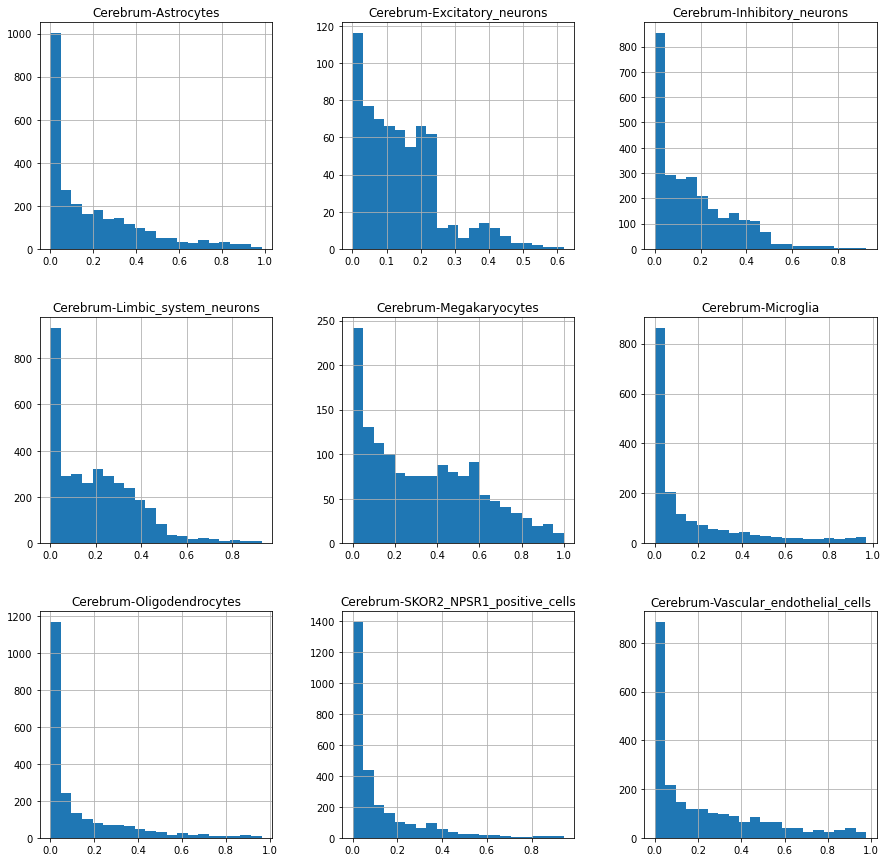

In [22]:
df[df>0].hist(bins=20, figsize=(15,15))

In [23]:
out_merged = f"{DATA_DIR}/Descartes_Human_Cerebrum.esmu.csv"
df.to_csv(out_merged)